In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from torchvision import models, transforms
import seaborn as sns
import matplotlib.pyplot as plt
!pip install timm
import timm
#Trying YOLOV - Kept gettin torch.cat() there is a null
import random
import shutil
import cv2
!pip install ultralytics
from ultralytics import YOLO

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.3/800.3 kB 22.3 MB/s eta 0:00:0000:01


# Load Data

In [2]:
train_path=r'/kaggle/input/face-expression-recognition-dataset/images/train'
test_path=r'/kaggle/input/face-expression-recognition-dataset/images/validation'

In [3]:
def load_data(path, img_size=(224, 224)):
    data = []
    labels = []
    for label in os.listdir(path):
        label_path = os.path.join(path, label)
        for img_name in os.listdir(label_path):
            img_path = os.path.join(label_path, img_name)
            img = cv2.imread(img_path)
            # Adding extra caution
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, img_size)
                data.append(img)
                labels.append(label)
    return data, labels

train_data, train_labels = load_data(train_path)
test_data, test_labels = load_data(test_path)

In [4]:
print(f'Train data length: {len(train_data)}, Train labels length: {len(train_labels)}')
print(f'Test data length: {len(test_data)}, Test labels length: {len(test_labels)}')

Train data length: 28821, Train labels length: 28821
Test data length: 7066, Test labels length: 7066


In [5]:
train_df = pd.DataFrame({'image': train_data, 'label': train_labels})
test_df = pd.DataFrame({'image': test_data, 'label': test_labels})

In [6]:
print(train_df['label'].unique())
num_classes=len(train_df['label'].unique())

['surprise' 'fear' 'angry' 'neutral' 'sad' 'disgust' 'happy']


## Encoding Labels

In [7]:
label_map = {label: idx for idx, label in enumerate(train_df['label'].unique())}
train_df['label'] = train_df['label'].map(label_map)
test_df['label'] = test_df['label'].map(label_map)

## Taking Random Subset & Train Test Split

In [9]:
def sample_images_per_class(df, num_samples_per_class=400):
    sampled_df = pd.DataFrame()
    for label in df['label'].unique():
        class_samples = df[df['label'] == label].sample(
            n=min(num_samples_per_class, len(df[df['label'] == label])), 
            random_state=42
        )
        sampled_df = pd.concat([sampled_df, class_samples])
    return sampled_df

train_sampled_df = sample_images_per_class(train_df, num_samples_per_class=400)
test_sampled_df = sample_images_per_class(test_df, num_samples_per_class=400)

# Shuffle the data
train_sampled_df = train_sampled_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_sampled_df = test_sampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [10]:
print(train_sampled_df['label'].value_counts())
print(test_sampled_df['label'].value_counts())

label
2    400
1    400
5    400
4    400
3    400
6    400
0    400
Name: count, dtype: int64
label
1    400
6    400
3    400
2    400
4    400
0    400
5    111
Name: count, dtype: int64


# Needed Functions & Classes

## Creating Yaml File

In [11]:
config_content = f"""
train: {train_path}
val: {test_path}

nc: 7

names:
  0: angry
  1: disgust
  2: fear
  3: happy
  4: neutral
  5: sad
  6: surprise
"""

# Write the configuration to the file
with open("dataset.yaml", "w") as f:
    f.write(config_content)

yaml_file_path = '/kaggle/working/dataset.yaml'

## Creating Transformers

In [12]:
class CustomDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = self.df.iloc[idx, 0]
        label = self.df.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### Creating Dataset & Loaders

In [13]:
train_dataset = CustomDataset(train_sampled_df, transform=transform)
test_dataset = CustomDataset(test_sampled_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluations Tracking & Training Functions

1. Model Evaluation: it returns the actual value and the predicted one
2. Confusion Matrix
3. Metrics planning for train/tess loss and accuracy

In [14]:
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Move to GPU
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    print(classification_report(y_true, y_pred, target_names=label_map.keys()))
    return y_true, y_pred

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def plot_metrics(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Training Loss')
    plt.plot(epochs, history['test_loss'], label='Testing Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Testing Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Training Accuracy')
    plt.plot(epochs, history['test_acc'], label='Testing Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Testing Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

## YOLOV Evaluation

In [15]:
def evaluate_yolo_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            preds = torch.tensor([x['class'] for x in outputs]).to(device)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    print(classification_report(y_true, y_pred, target_names=list(label_map.keys())))
    return y_true, y_pred


## Model Training

In [16]:
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs):
    history = {'train_loss': [], 'test_loss': [], 'train_acc': [], 'test_acc': []}

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}") as pbar:
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)  # Move to GPU
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

                pbar.update(1)

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)  # Move to GPU
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        test_loss /= len(test_loader)
        test_acc = correct / total

        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

    return history

## Logging Metrics Functions

In [17]:
# def log_metrics_to_tensorboard(writer, y_true, y_pred, history):
#     accuracy = accuracy_score(y_true, y_pred)
#     precision = precision_score(y_true, y_pred, average='weighted')
#     recall = recall_score(y_true, y_pred, average='weighted')
#     f1 = f1_score(y_true, y_pred, average='weighted')

#     writer.add_scalar("Accuracy", accuracy)
#     writer.add_scalar("Precision", precision)
#     writer.add_scalar("Recall", recall)
#     writer.add_scalar("F1_score", f1)

#     for epoch, (train_loss, test_loss, train_acc, test_acc) in enumerate(zip(history['train_loss'], history['test_loss'], history['train_acc'], history['test_acc']), 1):
#         writer.add_scalar(f"train_loss_epoch_{epoch}", train_loss)
#         writer.add_scalar(f"test_loss_epoch_{epoch}", test_loss)
#         writer.add_scalar(f"train_acc_epoch_{epoch}", train_acc)
#         writer.add_scalar(f"test_acc_epoch_{epoch}", test_acc)

# Training Models and Tensorboard Tracking

Few models to consider: 
1. Resnet50
2. DenseNet
3. InceptionV3
4. Vision Transformers ViT

In [18]:
number_epochs=25
learning_rate=0.001

## ViT 

In [19]:
def get_vit_model(num_classes):
    model = timm.create_model('vit_base_patch16_224', pretrained=True)
    model.head = nn.Linear(model.head.in_features, num_classes)
    return model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_vit_model(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

history = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=number_epochs)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch 1/25: 100%|██████████| 88/88 [00:53<00:00,  1.66it/s]


Epoch 1/25, Train Loss: 2.3257, Test Loss: 2.0569, Train Acc: 0.1568, Test Acc: 0.1593


Epoch 2/25: 100%|██████████| 88/88 [00:52<00:00,  1.67it/s]


Epoch 2/25, Train Loss: 1.9911, Test Loss: 1.9766, Train Acc: 0.1668, Test Acc: 0.1836


Epoch 3/25: 100%|██████████| 88/88 [00:52<00:00,  1.67it/s]


Epoch 3/25, Train Loss: 1.9812, Test Loss: 1.9461, Train Acc: 0.1743, Test Acc: 0.2031


Epoch 4/25: 100%|██████████| 88/88 [00:52<00:00,  1.67it/s]


Epoch 4/25, Train Loss: 1.9651, Test Loss: 1.9199, Train Acc: 0.1739, Test Acc: 0.2194


Epoch 5/25: 100%|██████████| 88/88 [00:52<00:00,  1.67it/s]


Epoch 5/25, Train Loss: 1.9475, Test Loss: 1.9204, Train Acc: 0.1754, Test Acc: 0.1884


Epoch 6/25: 100%|██████████| 88/88 [00:52<00:00,  1.67it/s]


Epoch 6/25, Train Loss: 1.9324, Test Loss: 1.9896, Train Acc: 0.1857, Test Acc: 0.1143


Epoch 7/25: 100%|██████████| 88/88 [00:52<00:00,  1.67it/s]


Epoch 7/25, Train Loss: 1.9408, Test Loss: 1.9162, Train Acc: 0.1629, Test Acc: 0.2067


Epoch 8/25: 100%|██████████| 88/88 [00:52<00:00,  1.67it/s]


Epoch 8/25, Train Loss: 1.9222, Test Loss: 1.9141, Train Acc: 0.1954, Test Acc: 0.2031


Epoch 9/25: 100%|██████████| 88/88 [00:52<00:00,  1.67it/s]


Epoch 9/25, Train Loss: 1.9176, Test Loss: 1.9471, Train Acc: 0.1896, Test Acc: 0.1971


Epoch 10/25: 100%|██████████| 88/88 [00:52<00:00,  1.67it/s]


Epoch 10/25, Train Loss: 1.9240, Test Loss: 1.9789, Train Acc: 0.1779, Test Acc: 0.1804


Epoch 11/25: 100%|██████████| 88/88 [00:52<00:00,  1.67it/s]


Epoch 11/25, Train Loss: 1.9189, Test Loss: 1.9019, Train Acc: 0.1882, Test Acc: 0.2051


Epoch 12/25: 100%|██████████| 88/88 [00:52<00:00,  1.67it/s]


Epoch 12/25, Train Loss: 1.9184, Test Loss: 1.9158, Train Acc: 0.1743, Test Acc: 0.2075


Epoch 13/25: 100%|██████████| 88/88 [00:52<00:00,  1.67it/s]


Epoch 13/25, Train Loss: 1.9150, Test Loss: 1.9426, Train Acc: 0.2014, Test Acc: 0.1848


Epoch 14/25: 100%|██████████| 88/88 [00:52<00:00,  1.67it/s]


Epoch 14/25, Train Loss: 1.9113, Test Loss: 1.8957, Train Acc: 0.1896, Test Acc: 0.1955


Epoch 15/25: 100%|██████████| 88/88 [00:52<00:00,  1.67it/s]


Epoch 15/25, Train Loss: 1.9119, Test Loss: 1.9201, Train Acc: 0.1914, Test Acc: 0.1832


Epoch 16/25: 100%|██████████| 88/88 [00:52<00:00,  1.67it/s]


Epoch 16/25, Train Loss: 1.9071, Test Loss: 1.8699, Train Acc: 0.1982, Test Acc: 0.2230


Epoch 17/25: 100%|██████████| 88/88 [00:52<00:00,  1.67it/s]


Epoch 17/25, Train Loss: 1.9079, Test Loss: 1.9067, Train Acc: 0.1889, Test Acc: 0.1764


Epoch 18/25: 100%|██████████| 88/88 [00:52<00:00,  1.67it/s]


Epoch 18/25, Train Loss: 1.8992, Test Loss: 1.9554, Train Acc: 0.2000, Test Acc: 0.1705


Epoch 19/25: 100%|██████████| 88/88 [00:52<00:00,  1.67it/s]


Epoch 19/25, Train Loss: 1.9026, Test Loss: 1.9070, Train Acc: 0.1961, Test Acc: 0.1967


Epoch 20/25: 100%|██████████| 88/88 [00:52<00:00,  1.67it/s]


Epoch 20/25, Train Loss: 1.8944, Test Loss: 1.9542, Train Acc: 0.2050, Test Acc: 0.1784


Epoch 21/25: 100%|██████████| 88/88 [00:52<00:00,  1.67it/s]


Epoch 21/25, Train Loss: 1.9103, Test Loss: 1.9119, Train Acc: 0.2100, Test Acc: 0.1776


Epoch 22/25: 100%|██████████| 88/88 [00:52<00:00,  1.67it/s]


Epoch 22/25, Train Loss: 1.9081, Test Loss: 1.9690, Train Acc: 0.1918, Test Acc: 0.1119


Epoch 23/25: 100%|██████████| 88/88 [00:52<00:00,  1.67it/s]


Epoch 23/25, Train Loss: 1.9049, Test Loss: 1.8876, Train Acc: 0.1964, Test Acc: 0.1983


Epoch 24/25: 100%|██████████| 88/88 [00:52<00:00,  1.67it/s]


Epoch 24/25, Train Loss: 1.9041, Test Loss: 1.9530, Train Acc: 0.2039, Test Acc: 0.1533


Epoch 25/25: 100%|██████████| 88/88 [00:52<00:00,  1.67it/s]


Epoch 25/25, Train Loss: 1.9050, Test Loss: 1.9366, Train Acc: 0.2004, Test Acc: 0.2071


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    surprise       0.26      0.56      0.35       400
        fear       0.00      0.00      0.00       400
       angry       0.12      0.00      0.00       400
     neutral       0.19      0.65      0.29       400
         sad       0.28      0.06      0.10       400
     disgust       0.06      0.09      0.07       111
       happy       0.00      0.00      0.00       400

    accuracy                           0.21      2511
   macro avg       0.13      0.20      0.12      2511
weighted avg       0.14      0.21      0.12      2511



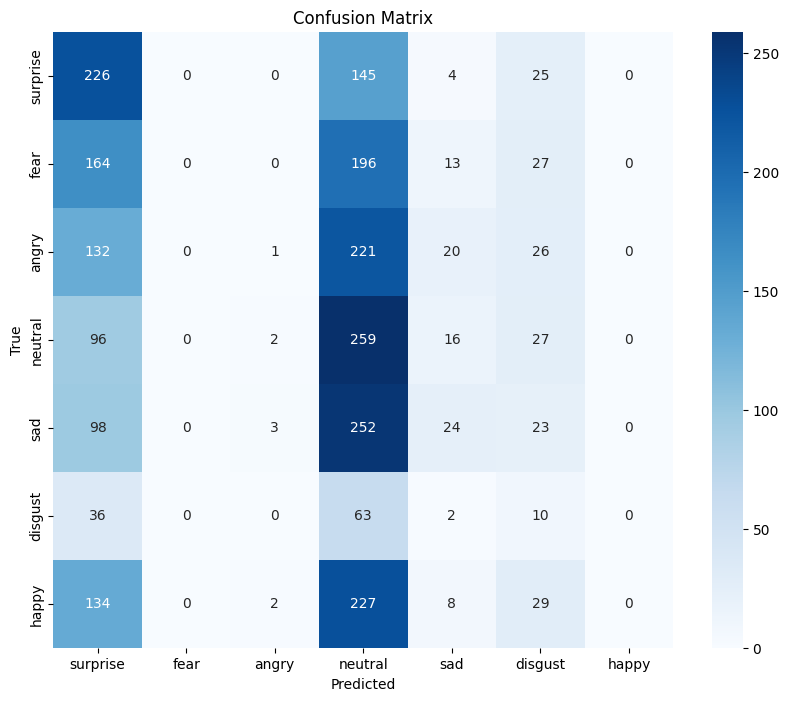

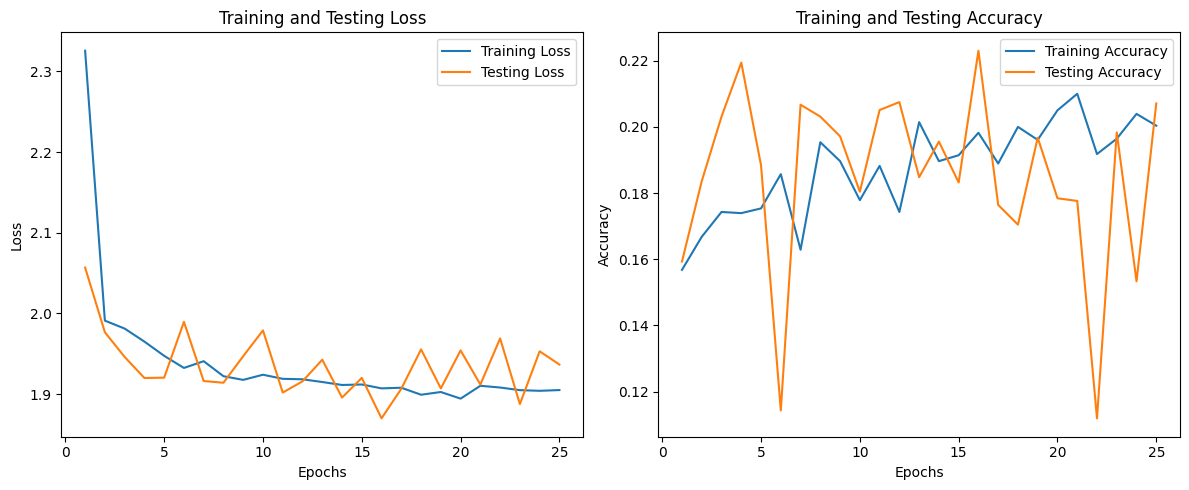

In [20]:
y_true, y_pred = evaluate_model(model, test_loader)
plot_confusion_matrix(y_true, y_pred, classes=list(label_map.keys()))
plot_metrics(history)

## ResNet50

In [21]:
def get_resnet50_model(num_classes):
    model = models.resnet50(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

model = get_resnet50_model(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
history = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=number_epochs)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 128MB/s] 
Epoch 1/25: 100%|██████████| 88/88 [00:16<00:00,  5.27it/s]


Epoch 1/25, Train Loss: 1.8971, Test Loss: 2.3807, Train Acc: 0.2504, Test Acc: 0.2561


Epoch 2/25: 100%|██████████| 88/88 [00:16<00:00,  5.33it/s]


Epoch 2/25, Train Loss: 1.7283, Test Loss: 1.6987, Train Acc: 0.3111, Test Acc: 0.3481


Epoch 3/25: 100%|██████████| 88/88 [00:16<00:00,  5.31it/s]


Epoch 3/25, Train Loss: 1.6302, Test Loss: 2.7440, Train Acc: 0.3586, Test Acc: 0.2453


Epoch 4/25: 100%|██████████| 88/88 [00:16<00:00,  5.34it/s]


Epoch 4/25, Train Loss: 1.5618, Test Loss: 1.8197, Train Acc: 0.4025, Test Acc: 0.3214


Epoch 5/25: 100%|██████████| 88/88 [00:16<00:00,  5.33it/s]


Epoch 5/25, Train Loss: 1.4794, Test Loss: 1.5882, Train Acc: 0.4318, Test Acc: 0.4098


Epoch 6/25: 100%|██████████| 88/88 [00:16<00:00,  5.32it/s]


Epoch 6/25, Train Loss: 1.3944, Test Loss: 1.6682, Train Acc: 0.4668, Test Acc: 0.3616


Epoch 7/25: 100%|██████████| 88/88 [00:16<00:00,  5.33it/s]


Epoch 7/25, Train Loss: 1.3117, Test Loss: 1.5233, Train Acc: 0.4900, Test Acc: 0.4146


Epoch 8/25: 100%|██████████| 88/88 [00:16<00:00,  5.34it/s]


Epoch 8/25, Train Loss: 1.2208, Test Loss: 1.5939, Train Acc: 0.5368, Test Acc: 0.3986


Epoch 9/25: 100%|██████████| 88/88 [00:16<00:00,  5.33it/s]


Epoch 9/25, Train Loss: 1.1382, Test Loss: 2.2885, Train Acc: 0.5757, Test Acc: 0.3158


Epoch 10/25: 100%|██████████| 88/88 [00:16<00:00,  5.35it/s]


Epoch 10/25, Train Loss: 1.0368, Test Loss: 1.5933, Train Acc: 0.6136, Test Acc: 0.4353


Epoch 11/25: 100%|██████████| 88/88 [00:16<00:00,  5.36it/s]


Epoch 11/25, Train Loss: 0.9618, Test Loss: 2.1479, Train Acc: 0.6393, Test Acc: 0.3751


Epoch 12/25: 100%|██████████| 88/88 [00:16<00:00,  5.35it/s]


Epoch 12/25, Train Loss: 0.8109, Test Loss: 2.0490, Train Acc: 0.7032, Test Acc: 0.3986


Epoch 13/25: 100%|██████████| 88/88 [00:16<00:00,  5.35it/s]


Epoch 13/25, Train Loss: 0.6809, Test Loss: 2.0240, Train Acc: 0.7425, Test Acc: 0.4082


Epoch 14/25: 100%|██████████| 88/88 [00:16<00:00,  5.36it/s]


Epoch 14/25, Train Loss: 0.5501, Test Loss: 2.4104, Train Acc: 0.8043, Test Acc: 0.3803


Epoch 15/25: 100%|██████████| 88/88 [00:16<00:00,  5.32it/s]


Epoch 15/25, Train Loss: 0.4607, Test Loss: 2.3475, Train Acc: 0.8379, Test Acc: 0.3994


Epoch 16/25: 100%|██████████| 88/88 [00:16<00:00,  5.35it/s]


Epoch 16/25, Train Loss: 0.3895, Test Loss: 2.7859, Train Acc: 0.8525, Test Acc: 0.3919


Epoch 17/25: 100%|██████████| 88/88 [00:16<00:00,  5.32it/s]


Epoch 17/25, Train Loss: 0.3070, Test Loss: 3.0164, Train Acc: 0.8904, Test Acc: 0.3911


Epoch 18/25: 100%|██████████| 88/88 [00:16<00:00,  5.37it/s]


Epoch 18/25, Train Loss: 0.2016, Test Loss: 2.9344, Train Acc: 0.9375, Test Acc: 0.4126


Epoch 19/25: 100%|██████████| 88/88 [00:16<00:00,  5.36it/s]


Epoch 19/25, Train Loss: 0.2415, Test Loss: 2.7324, Train Acc: 0.9175, Test Acc: 0.4126


Epoch 20/25: 100%|██████████| 88/88 [00:16<00:00,  5.34it/s]


Epoch 20/25, Train Loss: 0.1384, Test Loss: 2.9577, Train Acc: 0.9582, Test Acc: 0.4405


Epoch 21/25: 100%|██████████| 88/88 [00:16<00:00,  5.38it/s]


Epoch 21/25, Train Loss: 0.0940, Test Loss: 2.9446, Train Acc: 0.9646, Test Acc: 0.4313


Epoch 22/25: 100%|██████████| 88/88 [00:16<00:00,  5.37it/s]


Epoch 22/25, Train Loss: 0.0842, Test Loss: 3.0028, Train Acc: 0.9743, Test Acc: 0.4409


Epoch 23/25: 100%|██████████| 88/88 [00:16<00:00,  5.35it/s]


Epoch 23/25, Train Loss: 0.1091, Test Loss: 3.1182, Train Acc: 0.9629, Test Acc: 0.4401


Epoch 24/25: 100%|██████████| 88/88 [00:16<00:00,  5.36it/s]


Epoch 24/25, Train Loss: 0.0857, Test Loss: 3.1260, Train Acc: 0.9704, Test Acc: 0.4142


Epoch 25/25: 100%|██████████| 88/88 [00:16<00:00,  5.36it/s]


Epoch 25/25, Train Loss: 0.0851, Test Loss: 3.1823, Train Acc: 0.9707, Test Acc: 0.4277


              precision    recall  f1-score   support

    surprise       0.63      0.67      0.65       400
        fear       0.29      0.31      0.30       400
       angry       0.36      0.21      0.27       400
     neutral       0.40      0.42      0.41       400
         sad       0.32      0.38      0.35       400
     disgust       0.26      0.58      0.36       111
       happy       0.73      0.53      0.61       400

    accuracy                           0.43      2511
   macro avg       0.43      0.44      0.42      2511
weighted avg       0.45      0.43      0.43      2511



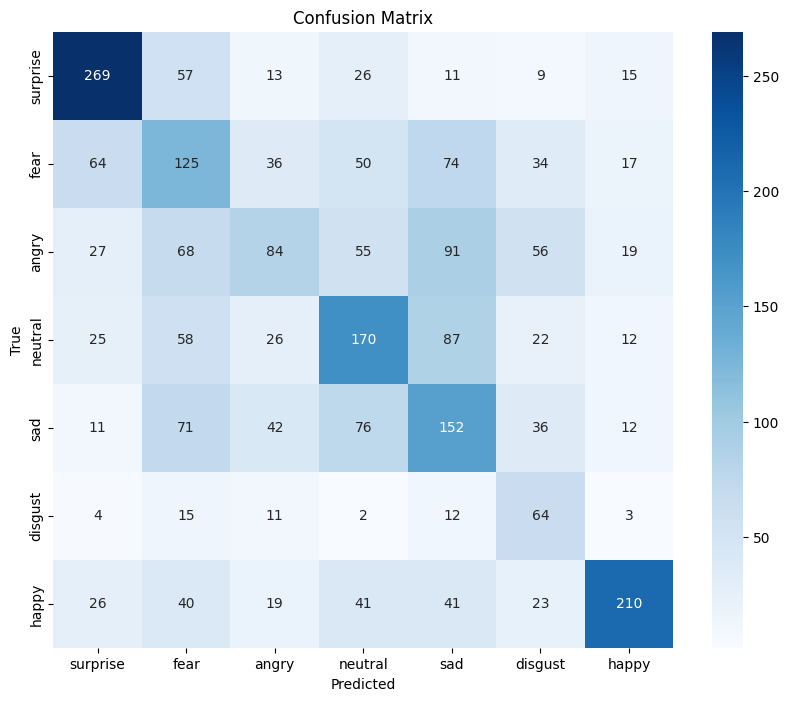

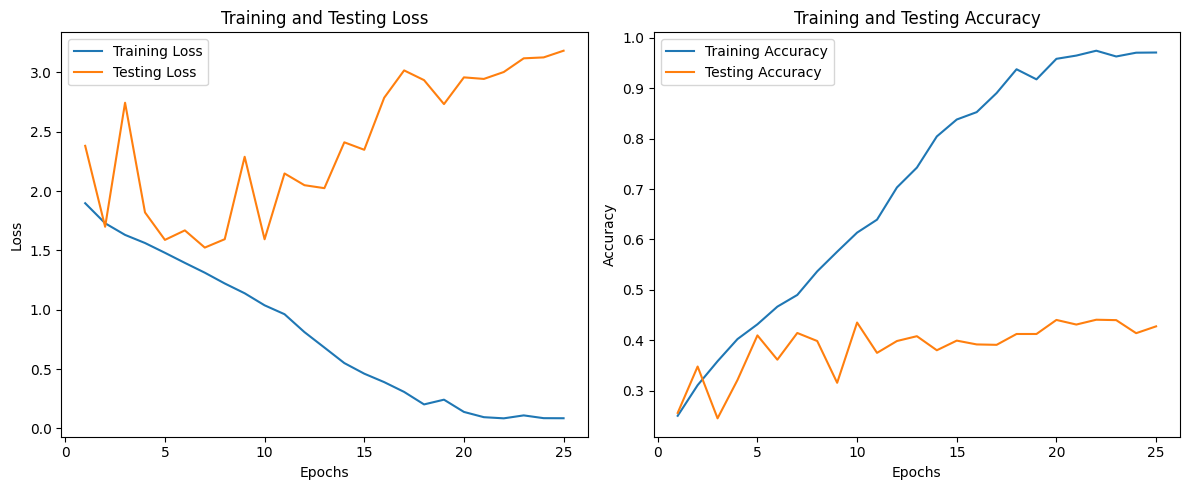

In [22]:
y_true, y_pred = evaluate_model(model, test_loader)
plot_confusion_matrix(y_true, y_pred, classes=list(label_map.keys()))
plot_metrics(history)

## NasNet


NASNet is a type of convolutional neural network discovered through neural architecture search. The building blocks consist of normal and reduction cells.

The error Kuda Error kept appearing

In [23]:
# def get_nasnet_model(num_classes):
#     model = timm.create_model('efficientnet_lite0', pretrained=True)
#     model.classifier = nn.Linear(model.classifier.in_features, num_classes)
#     return model

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = get_nasnet_model(num_classes).to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# history = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=number_epochs)


In [24]:
# y_true, y_pred = evaluate_model(model, test_loader)
# plot_confusion_matrix(y_true, y_pred, classes=list(label_map.keys()))
# # plot_metrics(history)

## Create a CNN - Scratch

In [45]:
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop = nn.Dropout(0.25)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 512, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(512)
        
        self.conv4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        
        self.fc1 = nn.Linear(512 * 14 * 14, 256)
        self.bn5 = nn.BatchNorm1d(256)
        
        self.fc2 = nn.Linear(256, 512)
        self.bn6 = nn.BatchNorm1d(512)
        
        self.fc3 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.drop(x)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.drop(x)
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.drop(x)
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.drop(x)
        x = x.view(-1, 512 * 14 * 14)  # Flatten the tensor based on input size
        x = F.relu(self.bn5(self.fc1(x)))
        x = self.drop(x)
        x = F.relu(self.bn6(self.fc2(x)))
        x = self.drop(x)
        x = self.fc3(x)
        return x


In [46]:
model = CustomCNN(num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [47]:
history = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=number_epochs)

Epoch 1/25: 100%|██████████| 88/88 [00:14<00:00,  6.12it/s]


Epoch 1/25, Train Loss: 1.9765, Test Loss: 1.9260, Train Acc: 0.1907, Test Acc: 0.2131


Epoch 2/25: 100%|██████████| 88/88 [00:14<00:00,  6.14it/s]


Epoch 2/25, Train Loss: 1.8230, Test Loss: 1.9327, Train Acc: 0.2750, Test Acc: 0.2362


Epoch 3/25: 100%|██████████| 88/88 [00:14<00:00,  6.14it/s]


Epoch 3/25, Train Loss: 1.7045, Test Loss: 1.7271, Train Acc: 0.3425, Test Acc: 0.3070


Epoch 4/25: 100%|██████████| 88/88 [00:14<00:00,  6.16it/s]


Epoch 4/25, Train Loss: 1.5379, Test Loss: 1.7156, Train Acc: 0.4236, Test Acc: 0.3206


Epoch 5/25: 100%|██████████| 88/88 [00:14<00:00,  6.15it/s]


Epoch 5/25, Train Loss: 1.3083, Test Loss: 1.7453, Train Acc: 0.5196, Test Acc: 0.3548


Epoch 6/25: 100%|██████████| 88/88 [00:14<00:00,  6.14it/s]


Epoch 6/25, Train Loss: 1.0856, Test Loss: 1.8666, Train Acc: 0.5971, Test Acc: 0.3441


Epoch 7/25: 100%|██████████| 88/88 [00:14<00:00,  6.16it/s]


Epoch 7/25, Train Loss: 0.8371, Test Loss: 1.9092, Train Acc: 0.7079, Test Acc: 0.3736


Epoch 8/25: 100%|██████████| 88/88 [00:14<00:00,  6.14it/s]


Epoch 8/25, Train Loss: 0.6178, Test Loss: 2.0588, Train Acc: 0.7954, Test Acc: 0.3867


Epoch 9/25: 100%|██████████| 88/88 [00:14<00:00,  6.15it/s]


Epoch 9/25, Train Loss: 0.4427, Test Loss: 2.3698, Train Acc: 0.8532, Test Acc: 0.3708


Epoch 10/25: 100%|██████████| 88/88 [00:14<00:00,  6.16it/s]


Epoch 10/25, Train Loss: 0.3336, Test Loss: 2.3136, Train Acc: 0.8893, Test Acc: 0.3863


Epoch 11/25: 100%|██████████| 88/88 [00:14<00:00,  6.14it/s]


Epoch 11/25, Train Loss: 0.2403, Test Loss: 2.3731, Train Acc: 0.9243, Test Acc: 0.3875


Epoch 12/25: 100%|██████████| 88/88 [00:14<00:00,  6.13it/s]


Epoch 12/25, Train Loss: 0.1777, Test Loss: 2.7119, Train Acc: 0.9414, Test Acc: 0.3783


Epoch 13/25: 100%|██████████| 88/88 [00:14<00:00,  6.13it/s]


Epoch 13/25, Train Loss: 0.1768, Test Loss: 2.5652, Train Acc: 0.9414, Test Acc: 0.3903


Epoch 14/25: 100%|██████████| 88/88 [00:14<00:00,  6.13it/s]


Epoch 14/25, Train Loss: 0.1889, Test Loss: 2.8275, Train Acc: 0.9393, Test Acc: 0.3700


Epoch 15/25: 100%|██████████| 88/88 [00:14<00:00,  6.12it/s]


Epoch 15/25, Train Loss: 0.1549, Test Loss: 2.7461, Train Acc: 0.9464, Test Acc: 0.3736


Epoch 16/25: 100%|██████████| 88/88 [00:14<00:00,  6.14it/s]


Epoch 16/25, Train Loss: 0.1442, Test Loss: 2.9074, Train Acc: 0.9525, Test Acc: 0.3672


Epoch 17/25: 100%|██████████| 88/88 [00:14<00:00,  6.13it/s]


Epoch 17/25, Train Loss: 0.1366, Test Loss: 2.8614, Train Acc: 0.9539, Test Acc: 0.3851


Epoch 18/25: 100%|██████████| 88/88 [00:14<00:00,  6.11it/s]


Epoch 18/25, Train Loss: 0.1300, Test Loss: 3.0366, Train Acc: 0.9546, Test Acc: 0.3867


Epoch 19/25: 100%|██████████| 88/88 [00:14<00:00,  6.10it/s]


Epoch 19/25, Train Loss: 0.1275, Test Loss: 3.0365, Train Acc: 0.9586, Test Acc: 0.3871


Epoch 20/25: 100%|██████████| 88/88 [00:14<00:00,  6.11it/s]


Epoch 20/25, Train Loss: 0.1011, Test Loss: 3.0070, Train Acc: 0.9661, Test Acc: 0.3740


Epoch 21/25: 100%|██████████| 88/88 [00:14<00:00,  6.10it/s]


Epoch 21/25, Train Loss: 0.0966, Test Loss: 3.1552, Train Acc: 0.9679, Test Acc: 0.3787


Epoch 22/25: 100%|██████████| 88/88 [00:14<00:00,  6.11it/s]


Epoch 22/25, Train Loss: 0.0887, Test Loss: 3.0508, Train Acc: 0.9714, Test Acc: 0.3923


Epoch 23/25: 100%|██████████| 88/88 [00:14<00:00,  6.13it/s]


Epoch 23/25, Train Loss: 0.0702, Test Loss: 3.2606, Train Acc: 0.9757, Test Acc: 0.3835


Epoch 24/25: 100%|██████████| 88/88 [00:14<00:00,  6.11it/s]


Epoch 24/25, Train Loss: 0.0622, Test Loss: 3.2119, Train Acc: 0.9793, Test Acc: 0.3919


Epoch 25/25: 100%|██████████| 88/88 [00:14<00:00,  6.14it/s]


Epoch 25/25, Train Loss: 0.0588, Test Loss: 3.3471, Train Acc: 0.9793, Test Acc: 0.3919


In [54]:
y_true, y_pred = evaluate_model(model, test_loader)

              precision    recall  f1-score   support

    surprise       0.53      0.63      0.57       400
        fear       0.30      0.24      0.27       400
       angry       0.32      0.29      0.30       400
     neutral       0.34      0.46      0.39       400
         sad       0.31      0.17      0.22       400
     disgust       0.32      0.71      0.44       111
       happy       0.54      0.48      0.51       400

    accuracy                           0.39      2511
   macro avg       0.38      0.42      0.39      2511
weighted avg       0.39      0.39      0.38      2511



In [55]:
plot_confusion_matrix(y_true, y_pred, classes=list(label_map.keys()))
plot_metrics(history)

# Zipping the Logs

In [ ]:
# shutil.make_archive('/kaggle/working/tensorboard_logs', 'zip', '/kaggle/working/tensorboard_logs')
# print("tensorboard_logs.zip file created successfully")3